This is the notebook to run the GRU network. It starts with a preprocessed file with p2_calib being the value to predict, and int_deliv_inv_ub and calib_time being the best values to use. It's important to note that at this point, some of the lumi measurements are taken a bit far from the calibration times. this can be seen by the difference between the lumi-section time and the calib_time values. The best data probably just consistents of the points where these are close.

All data is in its original units.

Also, I'm running this in the Python 3.7.1 Kernel

In [3]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker

In [4]:
#load the data
test = pd.read_csv('../data/test_diff.csv', index_col=0)
valid = pd.read_csv('../data/valid_diff.csv', index_col=0)
train = pd.read_csv('../data/train_diff.csv', index_col=0)
#set index to datetime periods
#test.index = pd.to_datetime(test.index).to_period('H')
#valid.index = pd.to_datetime(valid.index).to_period('H')
#train.index = pd.to_datetime(train.index).to_period('H')
#set index to datetime
test.index = pd.to_datetime(test.index)
valid.index = pd.to_datetime(valid.index)
train.index = pd.to_datetime(train.index)
train.head()

,p2,int_deliv_inv_ub
2018-05-12 09:01:31,0.000267,1.912590e+07
2018-05-12 10:01:31,0.000199,1.786448e+07
2018-05-12 11:01:31,0.000203,1.664305e+07
2018-05-12 12:01:31,0.000395,3.387666e+07
2018-05-12 13:01:31,0.000471,3.200991e+07


In [5]:
#now we will scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_scaler = MinMaxScaler() #we'll use the y-scaler later
y_scaler.fit(train[['p2']])
train[['p2', 'int_deliv_inv_ub']] = scaler.fit_transform(train)
train.describe()

,p2,int_deliv_inv_ub
count,2655.000000,2.655000e+03
mean,0.646483,2.679589e-01
std,0.163232,2.988668e-01
min,0.000000,0.000000e+00
25%,0.607612,5.605764e-07
50%,0.680520,1.461638e-01
75%,0.746537,5.184519e-01
max,1.000000,1.000000e+00


In [6]:
#number of lag variables and horizon (these are just some starting choices)
T = 10 #the past N hours to study
HORIZON = 1 #predict the next N hours

#sample tensor structure
tensor_structure = {'X':(range(-T+1, 1), ['p2', 'int_deliv_inv_ub'])}

#training tensor
train_input = TimeSeriesTensor(
    dataset=train,
    target="p2",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="H", #hours
    drop_incomplete=True, 
)

#validation tensor
valid_inputs = TimeSeriesTensor(valid, "p2", HORIZON, tensor_structure)
print(train_input['X'][0])
print(train_input['target'][0])
train_input['target'].shape
train_input['X'].shape

#print(valid_inputs['X'][0])
#print(valid_inputs['target'][0])

[[0.74345698 0.34552675]
 [0.7192607  0.32273805]
 [0.72090959 0.30067189]
 [0.78874195 0.6120126 ]
 [0.81582452 0.57828805]
 [0.75814882 0.54400623]
 [0.70862175 0.45460337]
 [0.79193564 0.37475713]
 [0.69902469 0.36397177]
 [0.45257292 0.46590702]]
[0.37370903]


(2645, 10, 2)

In [7]:
#now we bring in the keras tensorflow model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import LearningRateScheduler
from math import pow, floor
import time
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.00001
    drop = 0.5
    epochs_drop = 2.0
    lrate = initial_lrate * pow(drop, floor((1+epoch)/epochs_drop))
    return initial_lrate

v. 0 Latent_dim:  6 L2 Regularizer:  0.001 Optimizer: Adam Batch size: 1
Epoch 1/50
2645/2645 [==============================] - 10s 3ms/step - loss: 0.4923 - val_loss: 0.1436
Epoch 2/50
2645/2645 [==============================] - 7s 3ms/step - loss: 0.3039 - val_loss: 0.1598
Epoch 3/50
2645/2645 [==============================] - 7s 3ms/step - loss: 0.1666 - val_loss: 0.1824
Epoch 4/50
2645/2645 [==============================] - 8s 3ms/step - loss: 0.0772 - val_loss: 0.2084
Epoch 5/50
2645/2645 [==============================] - 7s 3ms/step - loss: 0.0350 - val_loss: 0.2279
Epoch 6/50
2645/2645 [==============================] - 8s 3ms/step - loss: 0.0252 - val_loss: 0.2338
Epoch 7/50
2645/2645 [==============================] - 8s 3ms/step - loss: 0.0241 - val_loss: 0.2349
Epoch 8/50
2645/2645 [==============================] - 7s 3ms/step - loss: 0.0232 - val_loss: 0.2355
Epoch 9/50
2645/2645 [==============================] - 7s 3ms/step - loss: 0.0232 - val_loss: 0.2360
Epoch 10

/panfs/roc/msisoft/anaconda/anaconda3-2018.12/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch 1/50
529/529 [==============================] - 3s 4ms/step - loss: 1.5877 - val_loss: 4.9785
Epoch 2/50
529/529 [==============================] - 2s 3ms/step - loss: 1.4342 - val_loss: 4.9526
Epoch 3/50
529/529 [==============================] - 2s 3ms/step - loss: 1.3130 - val_loss: 4.9305
Epoch 4/50
529/529 [==============================] - 2s 3ms/step - loss: 1.1726 - val_loss: 4.9112
Epoch 5/50
529/529 [==============================] - 2s 3ms/step - loss: 1.0521 - val_loss: 4.8938
Epoch 6/50
529/529 [==============================] - 2s 3ms/step - loss: 0.9412 - val_loss: 4.8780
Epoch 7/50
529/529 [==============================] - 2s 3ms/step - loss: 0.8097 - val_loss: 4.8636
Epoch 8/50
529/529 [==============================] - 2s 3ms/step - loss: 0.7363 - val_loss: 4.8504
Epoch 9/50
529/529 [==============================] - 2s 3ms/step - loss: 0.6327 - val_loss: 4.8385
Epoch 10/50
529/529 [==============================] - 2s 3ms/step - loss: 0.5351 - val_loss: 4.8276

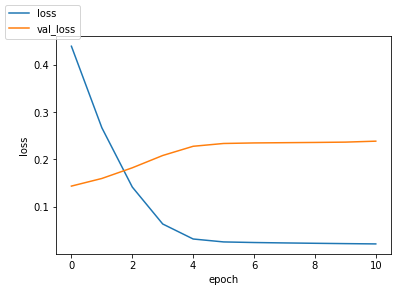

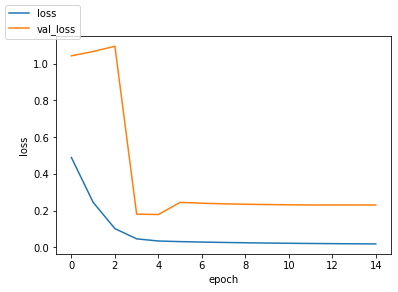

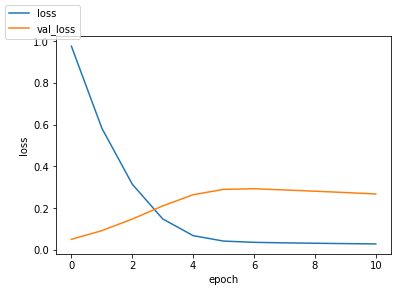

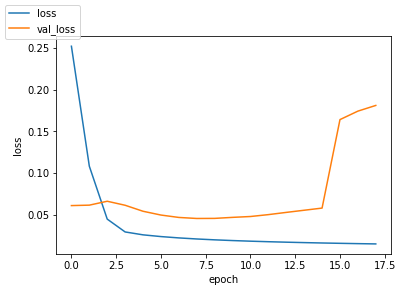

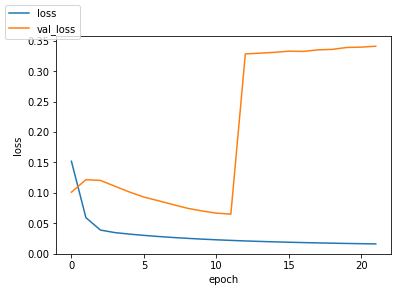

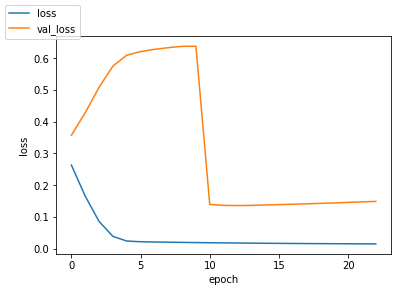

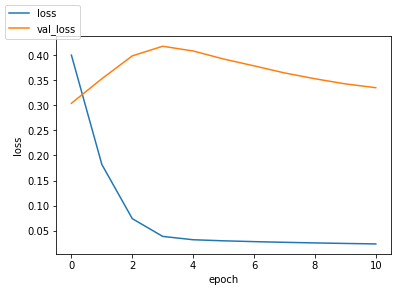

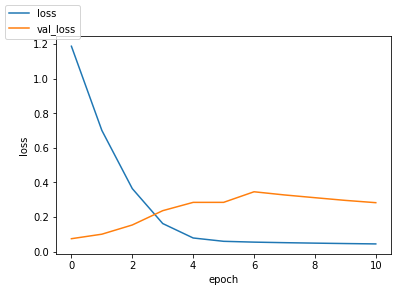

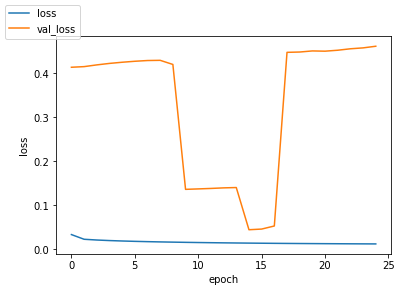

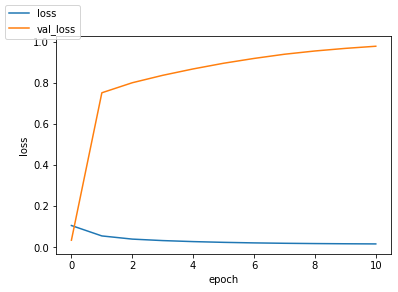

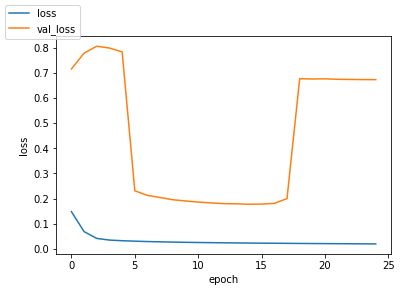

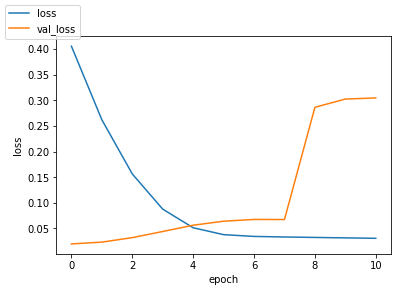

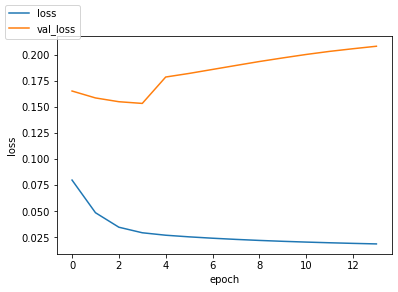

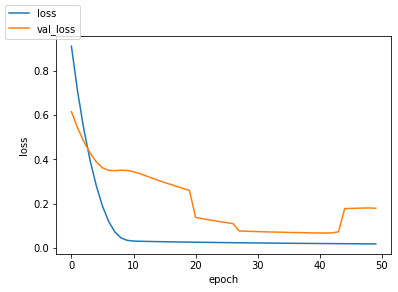

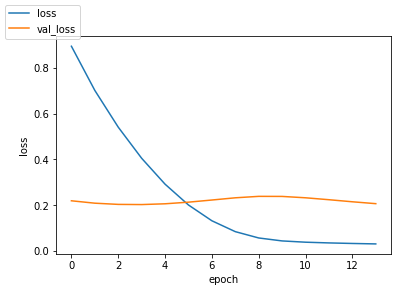

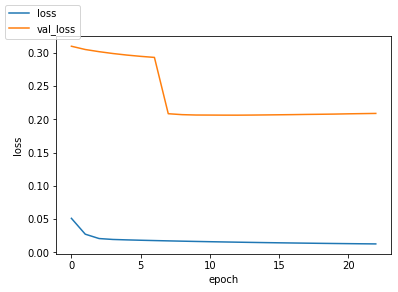

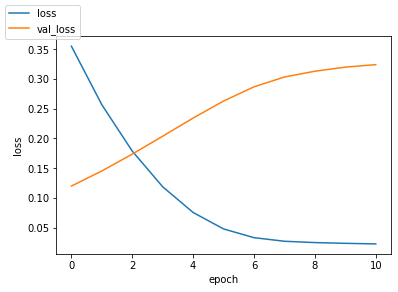

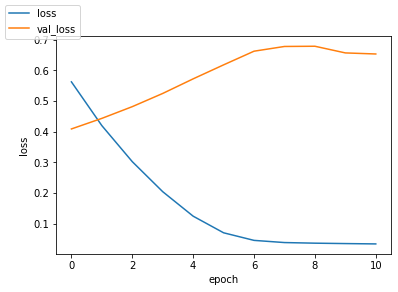

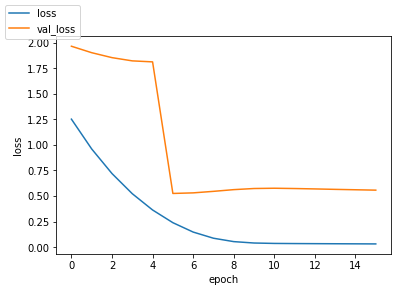

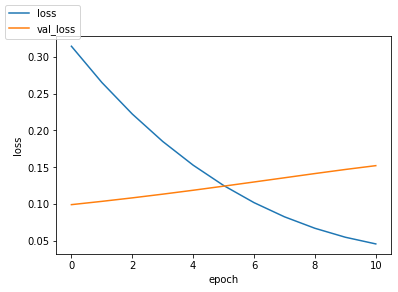

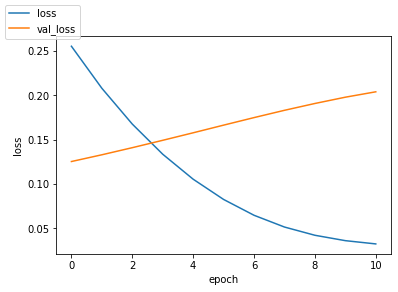

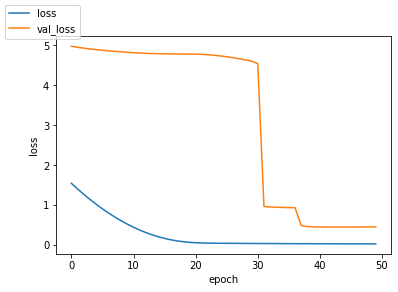

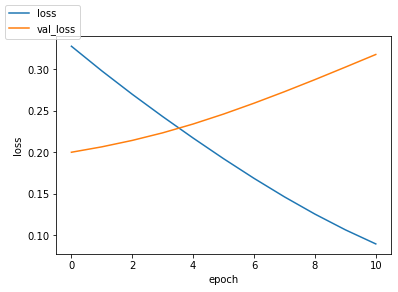

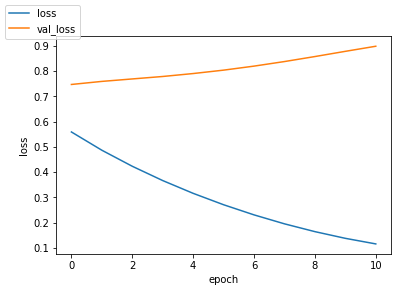

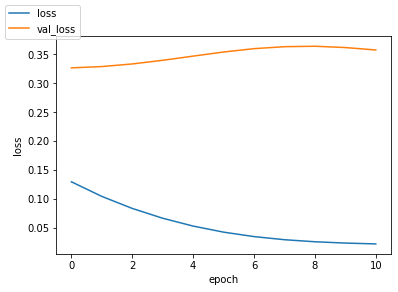

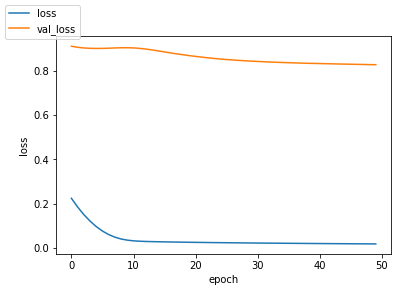

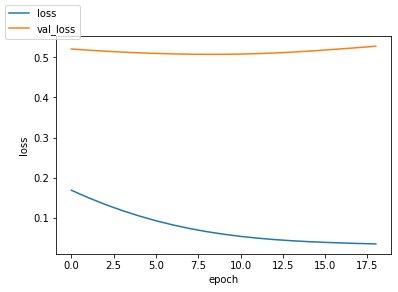

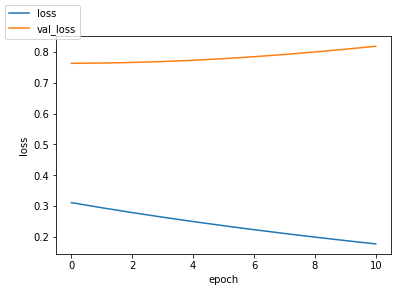

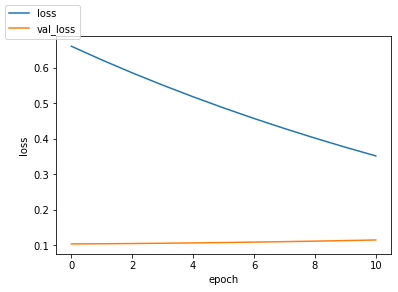

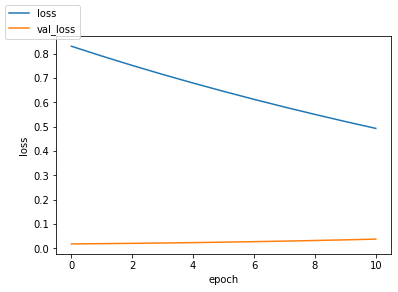

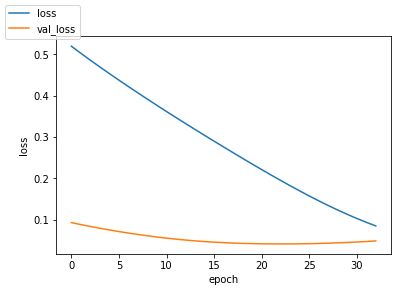

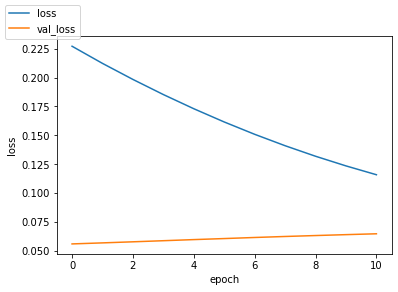

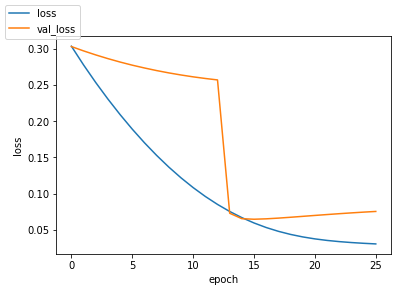

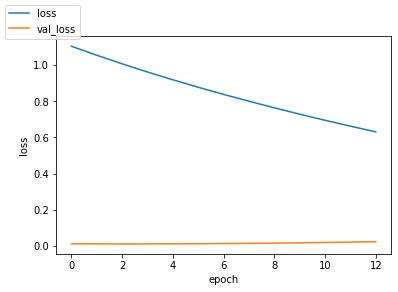

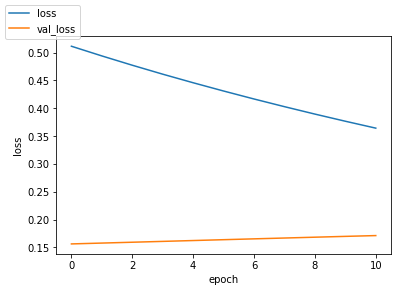

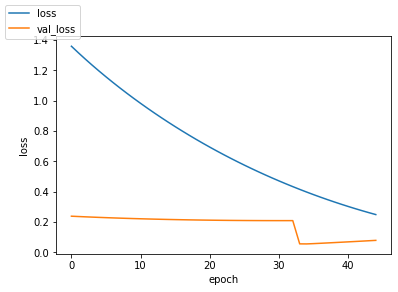

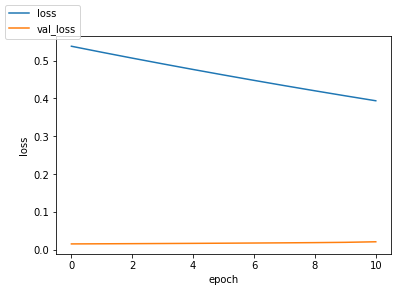

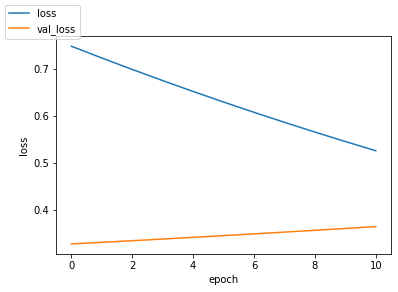

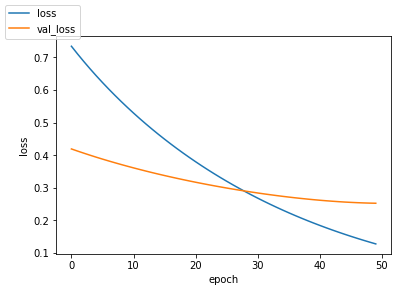

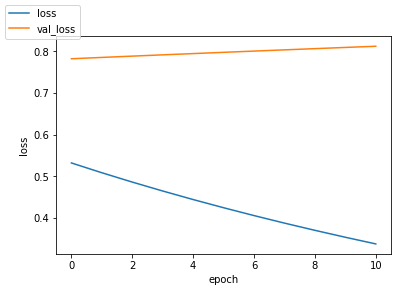

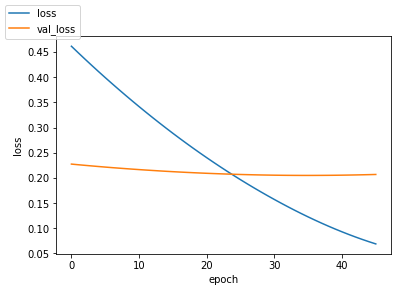

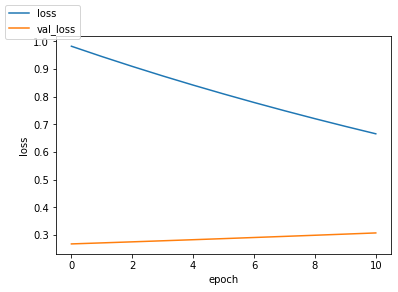

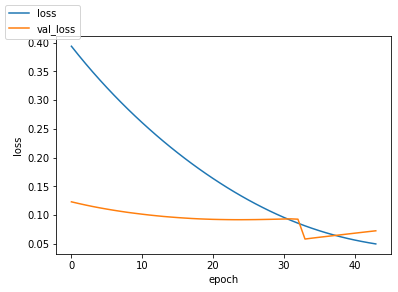

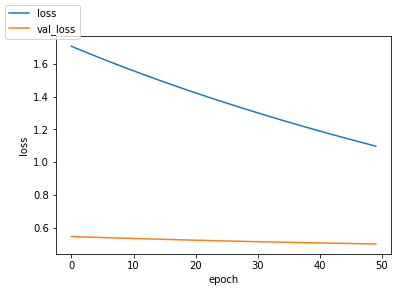

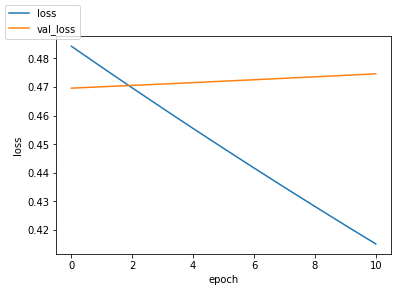

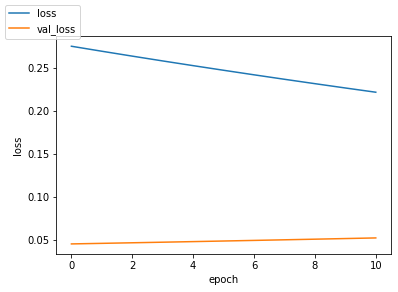

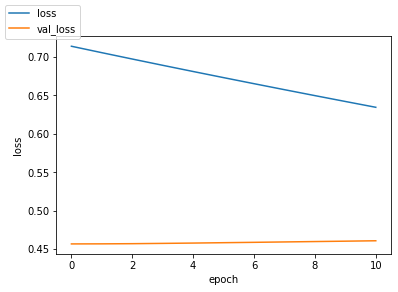

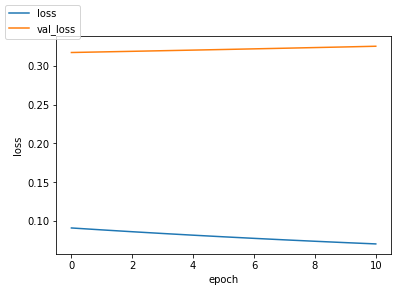

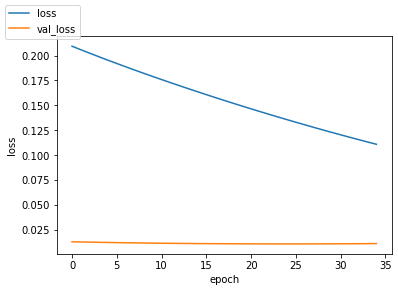

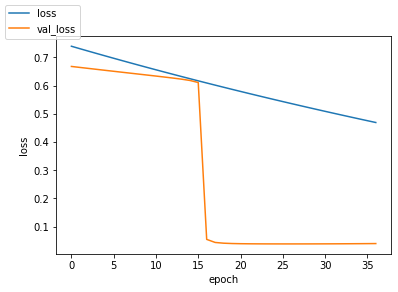

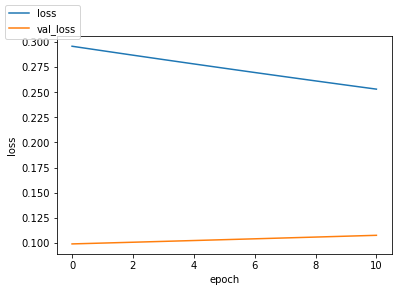

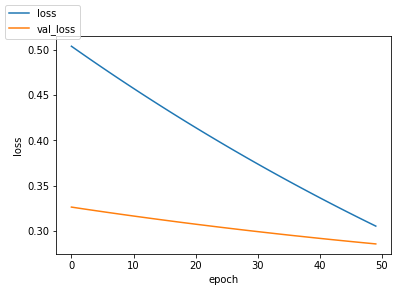

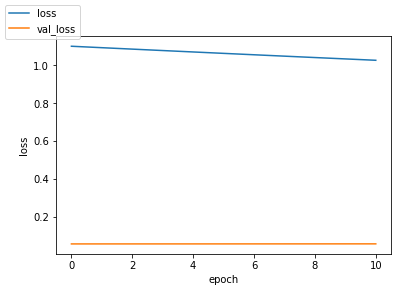

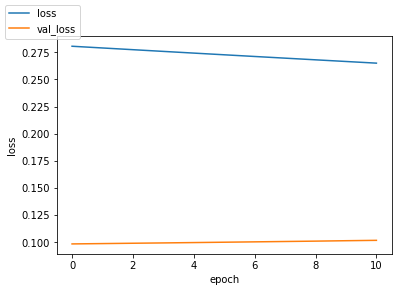

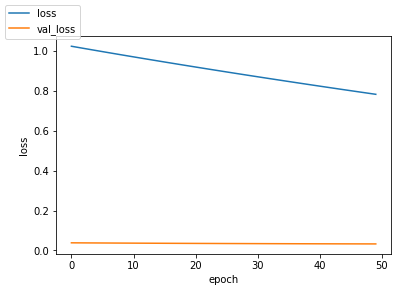

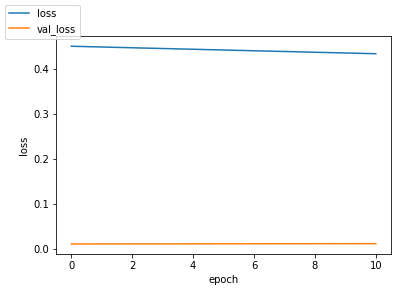

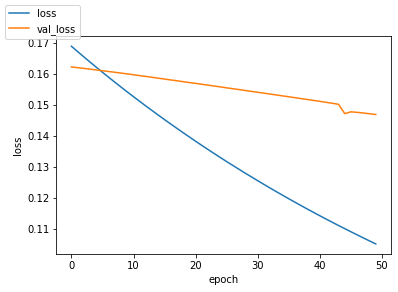

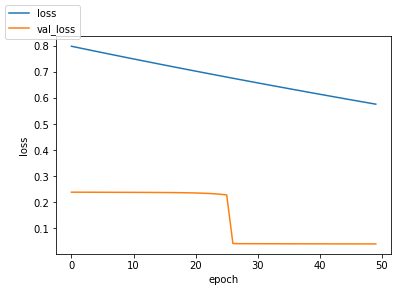

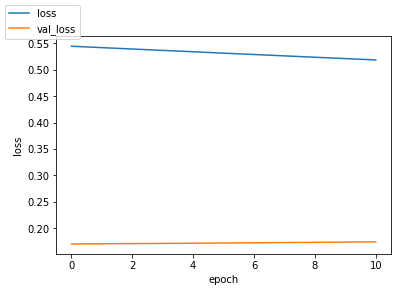

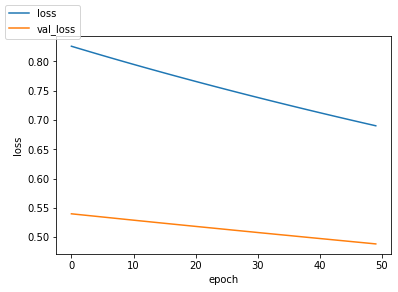

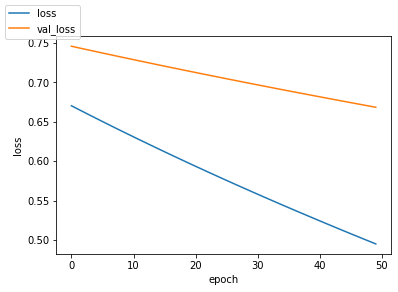

In [12]:
#best params:
#Latent_dim:  3 L2 Regularizer:  0.001
#Final Val Loss: 0.10678313672542572
reg_vals = [0.001]
optimizers = ['Adam']
val_results = []
batch_size = [1,2,5,10,20,50,100]
for ndim in range(6,7):
    for reg_val in reg_vals:
        for optimizer in optimizers:
            for batch in batch_size:
                for i in range(0,10):
                    print('v.',i,'Latent_dim: ',ndim,'L2 Regularizer: ', reg_val,'Optimizer:',optimizer, 'Batch size:',batch)
                    
                
                    t_start = time.time()
                    LATENT_DIM = ndim
                    BATCH_SIZE = batch
                    EPOCHS = 50

                    lrate = LearningRateScheduler(step_decay)
                    model = Sequential()
                    model.add(GRU(LATENT_DIM, input_shape=(T, 2), kernel_regularizer=l2(reg_val), recurrent_regularizer=l2(reg_val), bias_regularizer=l2(reg_val)))
                    #model.add(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
                    model.add(Dense(HORIZON))
                    model.compile(optimizer=optimizer, loss="mse", 
                                 # metrics=['accuracy']
                                 )

                    earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
                    model_history = model.fit(
                    train_input["X"],
                    train_input["target"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(valid_inputs["X"], valid_inputs["target"]),
                    callbacks=[earlystop, lrate],
                    verbose=1,
                    )
                    # list all data in history
                    #print(model_history.history.keys())
                    total_time = time.time()-t_start
                    # summarize history for loss
                    fig, ax = plt.subplots()
                    ax.plot(model_history.history['loss'])
                    ax.plot(model_history.history['val_loss'])

                    ax.set_ylabel('loss')
                    ax.set_xlabel('epoch')
                    fig.legend(['loss', 'val_loss'], loc='upper left')
                    #plt.show()
                    print('\tFinal Val Loss:',model_history.history['val_loss'][-1],' in: {}s'.format(total_time))
                    if(model_history.history['val_loss'][-1] < 1.0):
                        val_results.append((ndim,reg_val,model_history.history['val_loss'][-1],optimizer,total_time,batch,fig))
                    else:
                        plt.close()

In [34]:
#for result in val_results:
  #  print("ndim: ",result[0])
  #  print("reg_val: ",result[1])
  #  print("val_loss: ",result[2])
  #  print("optimizer: ",result[3])
df_results = pd.DataFrame(val_results, columns=['hidden_dimensions','L2_reg_val','final_val_loss','optimizer','training_time','batch_size','FIG'])
res_grps = df_results.groupby('batch_size')
for batch in batch_size:
    print('Batch size: {}'.format(batch))
    df_batch = res_grps.get_group(batch).drop(['batch_size','hidden_dimensions','L2_reg_val'],axis=1)
    print('\tAvg final val loss: {:.2f}+-{:.2f}'.format(df_batch.final_val_loss.mean(),df_batch.final_val_loss.std()))
    print('\tAvg training time: {:.2f}+-{:.2f}'.format(df_batch.training_time.mean(),df_batch.training_time.std()))
    
for count,result in enumerate(val_results):
    result[-1].savefig('loss-curve_batch-size_{}_{}.png'.format(result[-2],count))

Batch size: 1
	Avg final val loss: 0.35+-0.24
	Avg training time: 120.36+-43.04
Batch size: 2
	Avg final val loss: 0.37+-0.20
	Avg training time: 116.88+-77.02
Batch size: 5
	Avg final val loss: 0.46+-0.29
	Avg training time: 37.51+-30.27
Batch size: 10
	Avg final val loss: 0.21+-0.30
	Avg training time: 25.16+-11.47
Batch size: 20
	Avg final val loss: 0.25+-0.24
	Avg training time: 23.04+-14.18
Batch size: 50
	Avg final val loss: 0.25+-0.22
	Avg training time: 9.93+-5.18
Batch size: 100
	Avg final val loss: 0.20+-0.22
	Avg training time: 9.29+-3.88


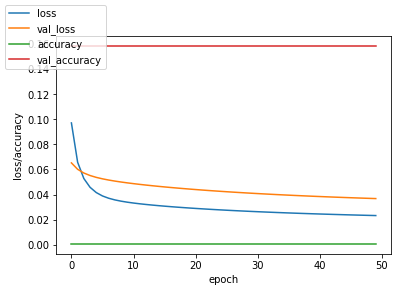

In [316]:
res_grps.get_group('Adagrad').FIG.iloc[4]

In [313]:
res_grps.get_group('Adagrad').iloc[4,:]

ndim                       6
reg_val             0.001000
val_loss            0.036842
optimizer            Adagrad
FIG          Figure(432x288)
Name: 22, dtype: object

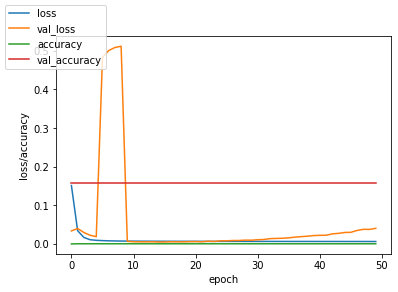

In [260]:
val_results[0][-1]

Latent_dim:  6 L2 Regularizer:  0.001 Optimizer: Adagrad
	Final Val Loss: 0.45652902126312256  in: 5.898316383361816s
	Initial Rate: 1e-05 Drop Rate: 5.0
Latent_dim:  6 L2 Regularizer:  0.001 Optimizer: Adagrad
	Final Val Loss: 0.28872957825660706  in: 6.103652715682983s
	Initial Rate: 1e-05 Drop Rate: 5.0
Latent_dim:  6 L2 Regularizer:  0.001 Optimizer: Adagrad
	Final Val Loss: 0.06719264388084412  in: 24.514267206192017s
	Initial Rate: 1e-05 Drop Rate: 5.0
Latent_dim:  6 L2 Regularizer:  0.001 Optimizer: Adagrad
	Final Val Loss: 0.6662638783454895  in: 24.471629858016968s
	Initial Rate: 1e-05 Drop Rate: 5.0
Latent_dim:  6 L2 Regularizer:  0.001 Optimizer: Adagrad
	Final Val Loss: 0.718900740146637  in: 5.661133050918579s
	Initial Rate: 1e-05 Drop Rate: 5.0
Latent_dim:  6 L2 Regularizer:  0.001 Optimizer: Adagrad
	Final Val Loss: 0.05677096173167229  in: 5.266754865646362s
	Initial Rate: 1e-05 Drop Rate: 5.0
Latent_dim:  6 L2 Regularizer:  0.001 Optimizer: Adagrad
	Final Val Loss: 0.3

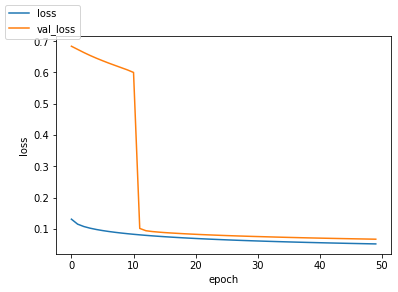

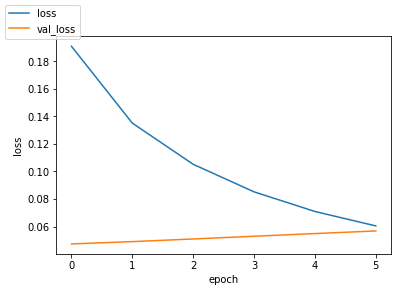

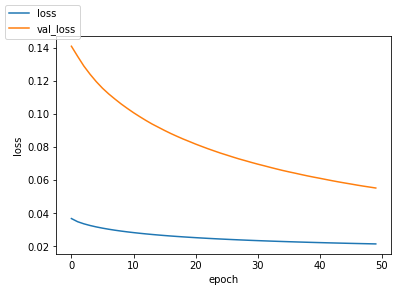

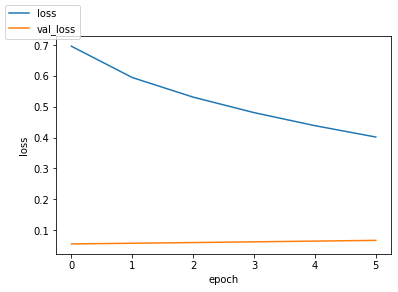

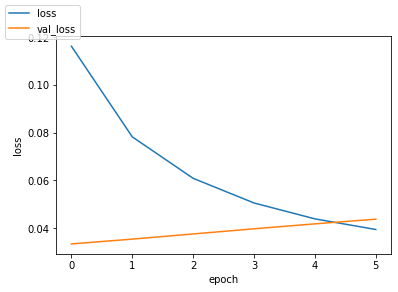

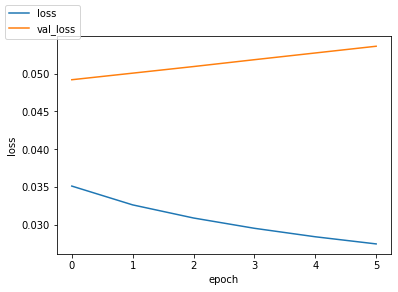

In [10]:
optimizer='Adagrad'
ndim = 6
reg_val = 0.001
val_results_2 = []
for i in range(0,20):
    t_start = time.time()
    LATENT_DIM = ndim
    BATCH_SIZE = 32
    EPOCHS = 50

    lrate = LearningRateScheduler(step_decay)
    model = Sequential()
    model.add(GRU(LATENT_DIM, input_shape=(T, 2), kernel_regularizer=l2(reg_val), recurrent_regularizer=l2(reg_val), bias_regularizer=l2(reg_val)))
    #model.add(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dense(HORIZON))
    model.compile(optimizer=optimizer, loss="mse", 
                 # metrics=['accuracy']
                 )

    earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
    model_history = model.fit(
    train_input["X"],
    train_input["target"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=0,
    )
    # list all data in history
    #print(model_history.history.keys())
    total_time = time.time()-t_start
    # summarize history for loss
    fig, ax = plt.subplots()
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])

    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    fig.legend(['loss', 'val_loss'], loc='upper left')
    #plt.show()
    print('Latent_dim: ',ndim,'L2 Regularizer: ', reg_val,'Optimizer:',optimizer)
    print('\tFinal Val Loss:',model_history.history['val_loss'][-1],' in: {}s'.format(total_time))
    print('\tInitial Rate:',rate,'Drop Rate:',drop_rate)
    if(model_history.history['val_loss'][-1] < .1):
        val_results_2.append((ndim,reg_val,model_history.history['val_loss'][-1],optimizer,total_time,rate,drop_rate,fig))
    else:
        plt.close()

Latent_dim:  4 L2 Regularizer:  0.0009
	Final Val Loss: 0.017432328313589096
Latent_dim:  4 L2 Regularizer:  0.0008
	Final Val Loss: 0.4258522391319275
Latent_dim:  4 L2 Regularizer:  0.0007
	Final Val Loss: 0.11330480873584747
Latent_dim:  4 L2 Regularizer:  0.0006
	Final Val Loss: 0.2054804116487503
Latent_dim:  4 L2 Regularizer:  0.0005
	Final Val Loss: 0.09329389035701752
Latent_dim:  4 L2 Regularizer:  0.0004
	Final Val Loss: 0.6892330050468445
Latent_dim:  4 L2 Regularizer:  0.0003
	Final Val Loss: 0.0772068053483963
Latent_dim:  4 L2 Regularizer:  0.0002
	Final Val Loss: 0.028480244800448418
Latent_dim:  4 L2 Regularizer:  0.0001
	Final Val Loss: 0.13109378516674042
Latent_dim:  5 L2 Regularizer:  0.0009
	Final Val Loss: 0.2836175560951233
Latent_dim:  5 L2 Regularizer:  0.0008
	Final Val Loss: 0.08848593384027481
Latent_dim:  5 L2 Regularizer:  0.0007
	Final Val Loss: 0.37576359510421753
Latent_dim:  5 L2 Regularizer:  0.0006
	Final Val Loss: 0.3508380651473999
Latent_dim:  5 L

/panfs/roc/msisoft/anaconda/anaconda3-2018.12/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Latent_dim:  6 L2 Regularizer:  0.0007
	Final Val Loss: 0.2187744379043579
Latent_dim:  6 L2 Regularizer:  0.0006
	Final Val Loss: 0.433796226978302
Latent_dim:  6 L2 Regularizer:  0.0005
	Final Val Loss: 0.09083852171897888
Latent_dim:  6 L2 Regularizer:  0.0004
	Final Val Loss: 0.23201508820056915
Latent_dim:  6 L2 Regularizer:  0.0003
	Final Val Loss: 0.05389290302991867
Latent_dim:  6 L2 Regularizer:  0.0002
	Final Val Loss: 0.060377009212970734
Latent_dim:  6 L2 Regularizer:  0.0001
	Final Val Loss: 0.06715875118970871


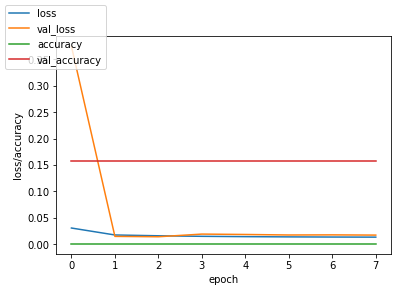

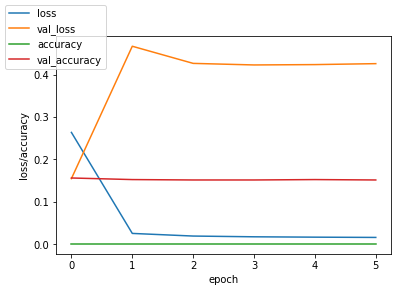

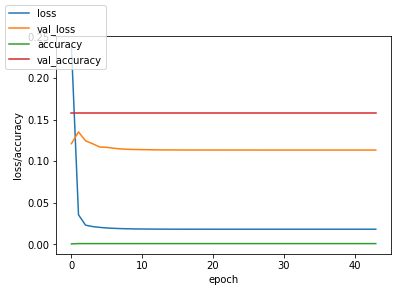

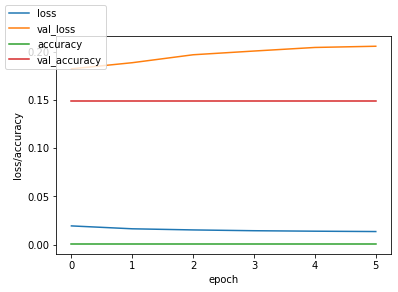

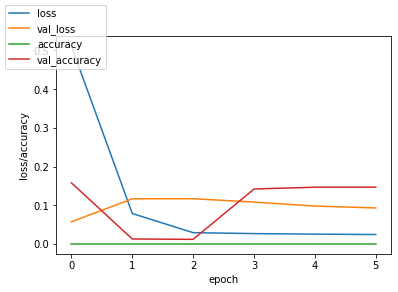

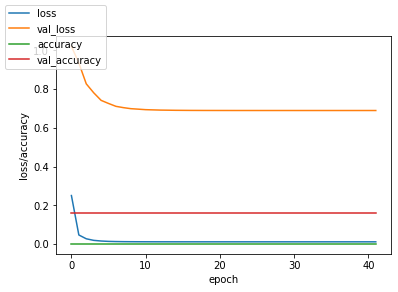

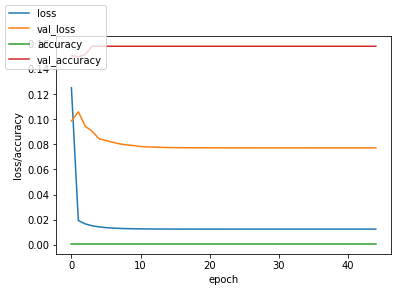

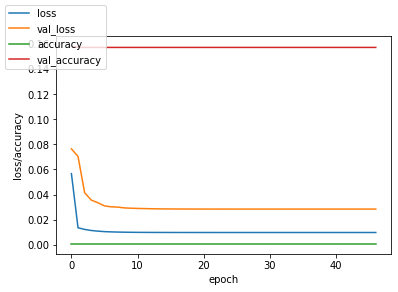

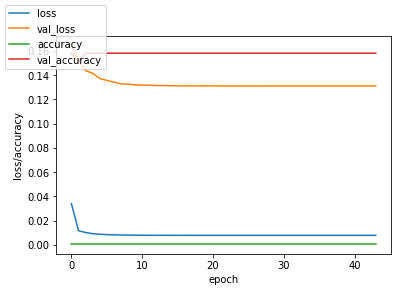

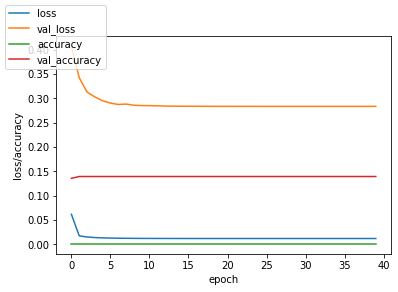

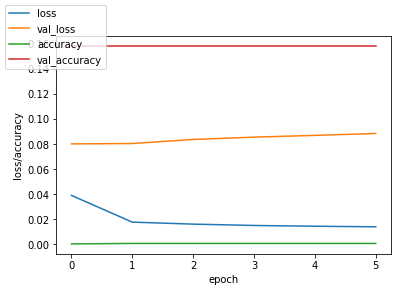

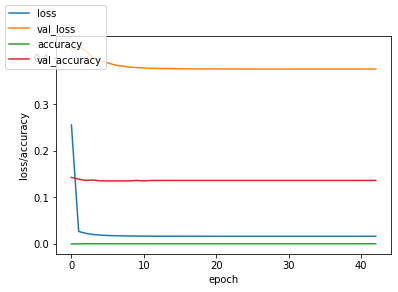

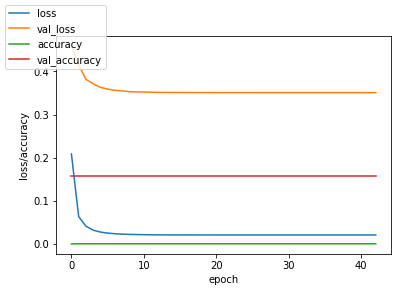

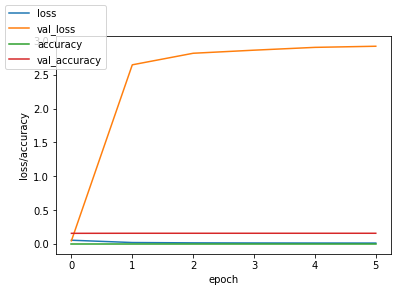

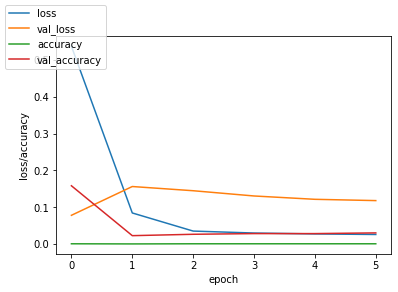

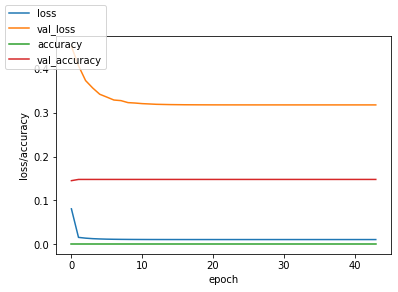

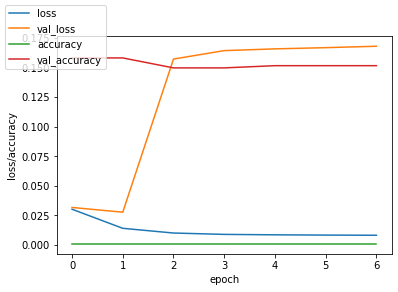

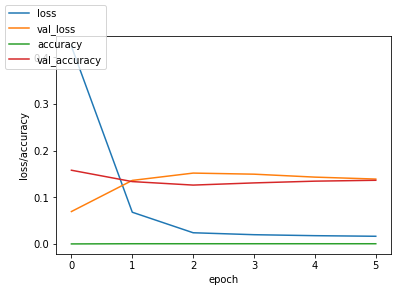

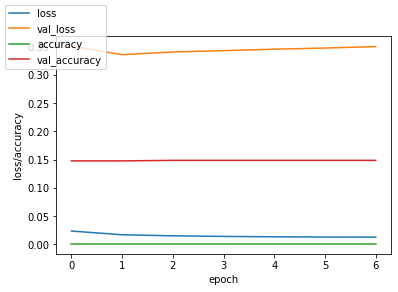

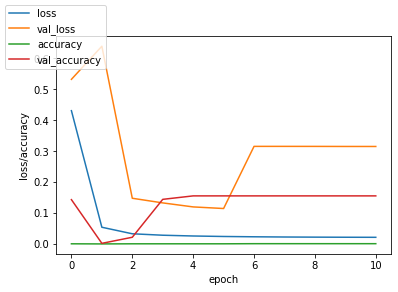

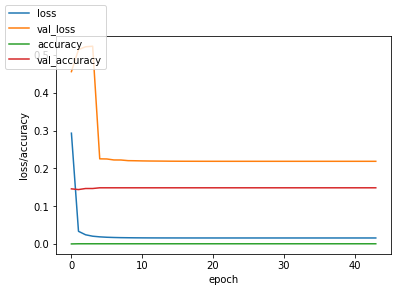

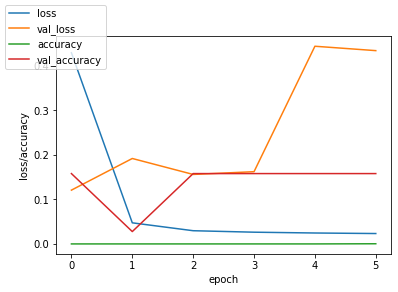

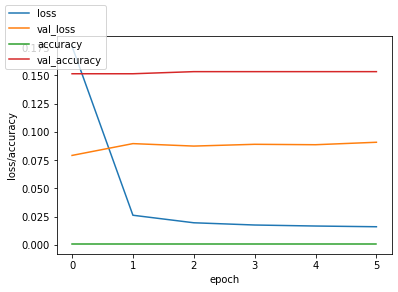

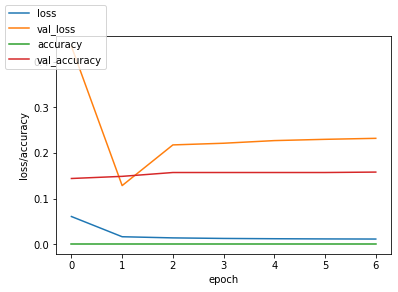

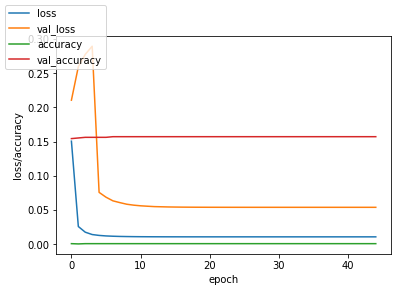

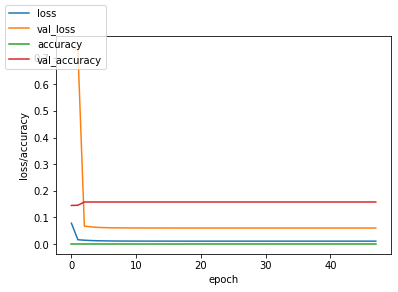

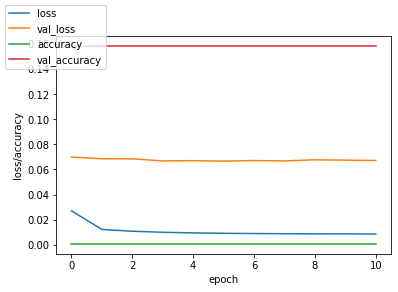

In [247]:
#best param 
#ndim:  5
#reg_val:  0.0005
#val_loss:  0.02076718583703041
reg_vals = [0.0009,0.0008,0.0007,0.0006, 0.0005,0.0004,0.0003, 0.0002, 0.0001]
val_results_2 = []
for ndim in range(4,7):
    for reg_val in reg_vals:
        LATENT_DIM = ndim
        BATCH_SIZE = 32
        EPOCHS = 50

        lrate = LearningRateScheduler(step_decay)
        model = Sequential()
        model.add(GRU(LATENT_DIM, input_shape=(T, 2), kernel_regularizer=l2(reg_val), recurrent_regularizer=l2(reg_val), bias_regularizer=l2(reg_val)))
        #model.add(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        model.add(Dense(HORIZON))
        model.compile(optimizer="RMSprop", loss="mse", metrics=['accuracy'])

        earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
        model_history = model.fit(
        train_input["X"],
        train_input["target"],
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(valid_inputs["X"], valid_inputs["target"]),
        callbacks=[earlystop,lrate],
        verbose=0,
        )
        # list all data in history
        #print(model_history.history.keys())

        # summarize history for loss
        fig, ax = plt.subplots()
        ax.plot(model_history.history['loss'])
        ax.plot(model_history.history['val_loss'])
        ax.plot(model_history.history['accuracy'])
        ax.plot(model_history.history['val_accuracy'])
        
        ax.set_ylabel('loss/accuracy')
        ax.set_xlabel('epoch')
        fig.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'], loc='upper left')
        #plt.show()
        print('Latent_dim: ',ndim,'L2 Regularizer: ', reg_val)
        print('\tFinal Val Loss:',model_history.history['val_loss'][-1])
        if(model_history.history['val_loss'][-1] < .1):
            val_results_2.append((ndim,reg_val,model_history.history['val_loss'][-1],fig))

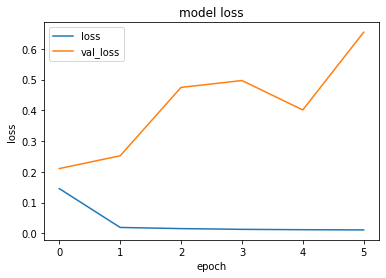

In [244]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [191]:
#now we'll test
data_test_inputs = TimeSeriesTensor(test, "p2", HORIZON, tensor_structure)
#print(data_test_inputs['X'][0])
#print(data_test_inputs['target'][0])

predictions = model.predict(data_test_inputs["X"])
#print(predictions)
ev_data = create_evaluation_df(predictions, data_test_inputs, HORIZON, y_scaler)
ev_groups = ev_data.groupby('h')
#test.head()
ev_groups.get_group('t+1')

,timestamp,h,prediction,actual
0,2018-10-15 10:36:23,t+1,-0.000774,-0.001831
1,2018-10-15 11:36:23,t+1,-0.000765,-0.001830
2,2018-10-15 12:36:23,t+1,-0.000760,-0.001830
3,2018-10-15 13:36:23,t+1,-0.000758,-0.001830
4,2018-10-15 14:36:23,t+1,-0.000756,-0.001830
...,...,...,...,...
1149,2018-12-02 07:36:23,t+1,-0.001919,-0.001831
1150,2018-12-02 08:36:23,t+1,-0.002118,-0.001831
1151,2018-12-02 09:36:23,t+1,-0.002258,-0.001831
1152,2018-12-02 10:36:23,t+1,-0.002340,-0.001831


In [192]:
gr1 = ev_groups.get_group('t+1')
gr2 = ev_groups.get_group('t+2')
gr3 = ev_groups.get_group('t+3')

mape1 = mape(gr1.prediction, gr1.actual)
mape2 = mape(gr2.prediction, gr2.actual)
mape3 = mape(gr3.prediction, gr3.actual)
print('Evaluating GRU')
print("MAPE prediction 1 hour  ahead: {:.1%}".format(mape1),
      "\nMAPE prediction 2 hours ahead: {:.1%}".format(mape2),
      "\nMAPE prediction 3 hours ahead: {:.1%}".format(mape3))

Evaluating GRU
MAPE prediction 1 hour  ahead: -36.6% 
MAPE prediction 2 hours ahead: -56.1% 
MAPE prediction 3 hours ahead: -45.8%


/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


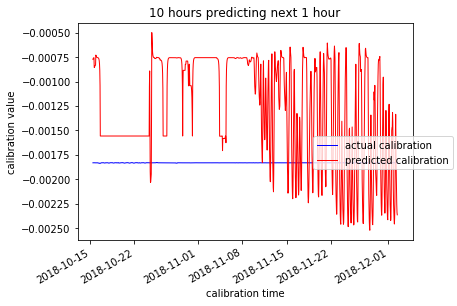

In [193]:
#lets plot our results
fig, ax = plt.subplots()

ev_group = ev_groups.get_group('t+1')

ax.set_title('{time:.0f} hours predicting next 1 hour'.format(time=T))
ax.set_ylabel('calibration value')
ax.set_xlabel('calibration time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax.plot(ev_group.timestamp, ev_group.actual, 
         label='actual calibration', color='blue', linewidth=1, linestyle='solid')

ax.plot(ev_group.timestamp, ev_group.prediction, 
         label='predicted calibration', color='red', linewidth=1, linestyle='solid')
#legend
fig.legend(ncol=1, loc = 'right')
fig.show()

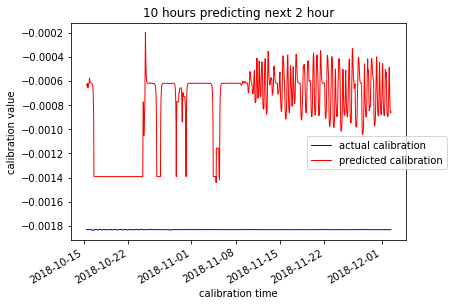

In [194]:
#lets plot our results
fig, ax = plt.subplots()

ev_group = ev_groups.get_group('t+2')

ax.set_title('{time:.0f} hours predicting next 2 hour'.format(time=T))
ax.set_ylabel('calibration value')
ax.set_xlabel('calibration time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax.plot(ev_group.timestamp, ev_group.actual, 
         label='actual calibration', color='blue', linewidth=1, linestyle='solid')

ax.plot(ev_group.timestamp, ev_group.prediction, 
         label='predicted calibration', color='red', linewidth=1, linestyle='solid')
#legend
fig.legend(ncol=1, loc = 'right')
fig.show()

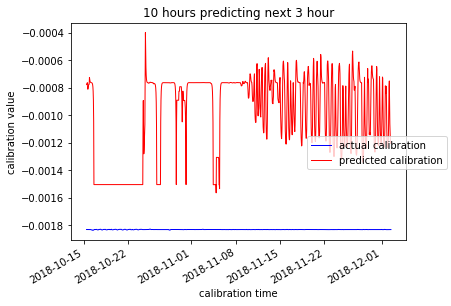

In [195]:
#lets plot our results
fig, ax = plt.subplots()

ev_group = ev_groups.get_group('t+3')

ax.set_title('{time:.0f} hours predicting next 3 hour'.format(time=T))
ax.set_ylabel('calibration value')
ax.set_xlabel('calibration time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax.plot(ev_group.timestamp, ev_group.actual, 
         label='actual calibration', color='blue', linewidth=1, linestyle='solid')

ax.plot(ev_group.timestamp, ev_group.prediction, 
         label='predicted calibration', color='red', linewidth=1, linestyle='solid')
#legend
fig.legend(ncol=1, loc = 'right')
fig.show()

In [56]:
#our data is transformed to feed into the model. The diff step transforms the data by removing the large scale trends. We'll run that in reverse to look at the data with the trends.
ev_data_int = ev_data.copy()
ev_data_int['prediction'] = ev_data_int['prediction'].cumsum()
ev_data_int['actual'] = ev_data_int['actual'].cumsum()
ev_data.head()

,timestamp,h,prediction,actual
0,2018-10-16 00:36:23,t+1,0.091013,-0.000088
1,2018-10-16 01:36:23,t+1,0.092886,0.000015
2,2018-10-16 02:36:23,t+1,0.097010,-0.000005
3,2018-10-16 03:36:23,t+1,0.100895,0.000120
4,2018-10-16 04:36:23,t+1,0.103939,-0.000001


/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


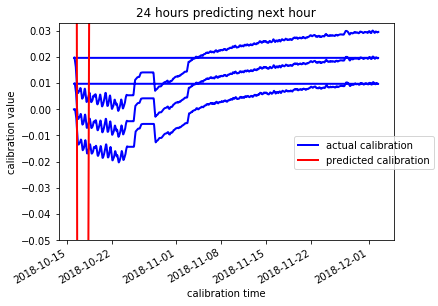

In [57]:
#lets plot our results
fig10, ax13 = plt.subplots()

ax13.set_title('{time:.0f} hours predicting next hour'.format(time=T))
ax13.set_ylabel('calibration value')
ax13.set_xlabel('calibration time')
plt.setp(ax13.get_xticklabels(), rotation=30, horizontalalignment='right')

ax13.plot(ev_data_int.timestamp, ev_data_int.actual, 
         label='actual calibration', color='blue', linewidth=2, linestyle='solid')

ax13.plot(ev_data_int.timestamp, ev_data_int.prediction, 
         label='predicted calibration', color='red', linewidth=2, linestyle='solid')

#lumi data on alternate y axis
#ax14 = ax13.twinx()
#ax14.set_ylabel('integrated luminosity (/ub)')
#
#ax14.plot(test_lumi_avg.index, test_lumi_avg, 
#         label='lumi averaged', color='limegreen', linewidth=1, linestyle='dashed')

#legend
fig10.legend(ncol=1, loc='right')
plt.ylim([-.05, ev_data_int.actual.max()*1.1])
fig10.show()